1. Importar as bibliotecas

Saving visitas.csv to visitas (1).csv
Saving pacientes.csv to pacientes (1).csv
Saving eventos_adversos.csv to eventos_adversos (1).csv
Arquivos disponíveis: ['visitas (1).csv', 'pacientes (1).csv', 'eventos_adversos (1).csv']

Colunas em pacientes.csv: ['ID_Paciente', 'Idade', 'Sexo', 'Centro', 'Grupo']
Colunas em visitas.csv: ['ID_Paciente', 'Data_Visita', 'PA_Sistolica', 'PA_Diastolica', 'IMC', 'Glicemia', 'Adesao', 'Evento_Adverso']
Colunas em eventos_adversos.csv: ['ID_Paciente', 'Data_Visita', 'PA_Sistolica', 'PA_Diastolica', 'IMC', 'Glicemia', 'Adesao', 'Evento_Adverso', 'Gravidade']

Dados combinados com sucesso!

Acurácia: 0.7297297297297297

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.73      1.00      0.84        54
           1       0.00      0.00      0.00        20

    accuracy                           0.73        74
   macro avg       0.36      0.50      0.42        74
weighted avg       0.53      0.73      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


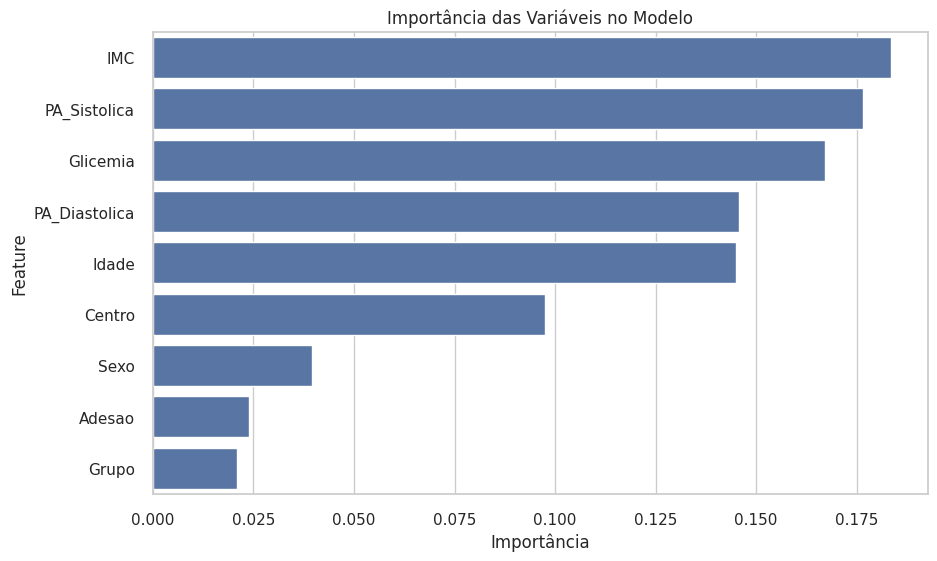

In [7]:
# Importar bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Configurar estilo dos gráficos
plt.style.use('ggplot')  # Alternativa mais estável que 'seaborn'
sns.set_theme(style="whitegrid")
%matplotlib inline

# 1. Carregar os dados
from google.colab import files
uploaded = files.upload()

# Verificar arquivos carregados
print("Arquivos disponíveis:", list(uploaded.keys()))

# Carregar cada arquivo
pacientes = pd.read_csv(next(f for f in uploaded.keys() if 'pacientes' in f.lower()))
visitas = pd.read_csv(next(f for f in uploaded.keys() if 'visitas' in f.lower()))
eventos = pd.read_csv(next(f for f in uploaded.keys() if 'eventos' in f.lower()))

# 2. Verificar colunas disponíveis
print("\nColunas em pacientes.csv:", pacientes.columns.tolist())
print("Colunas em visitas.csv:", visitas.columns.tolist())
print("Colunas em eventos_adversos.csv:", eventos.columns.tolist())

# 3. Corrigir nome da coluna de ID (se necessário)
# Se a coluna se chama 'ID' em vez de 'ID_Paciente':
pacientes = pacientes.rename(columns={'ID': 'ID_Paciente'}) if 'ID' in pacientes.columns else pacientes
visitas = visitas.rename(columns={'ID': 'ID_Paciente'}) if 'ID' in visitas.columns else visitas

# 4. Combinar os dados
try:
    dados = pd.merge(visitas, pacientes, on="ID_Paciente", how="left")
    print("\nDados combinados com sucesso!")
except KeyError:
    # Tentar encontrar a coluna de ID correta
    id_col = [col for col in visitas.columns if col in pacientes.columns and 'id' in col.lower()]
    if id_col:
        dados = pd.merge(visitas, pacientes, on=id_col[0], how="left")
        print(f"\nDados combinados usando a coluna {id_col[0]}")
    else:
        raise KeyError("Não foi possível encontrar coluna de ID comum entre os datasets")

# 5. Pré-processamento
# Criar variável alvo
dados['Evento_Adverso'] = dados['Evento_Adverso'].apply(lambda x: 0 if x == 'Nenhum' else 1)

# Codificar variáveis categóricas
categorical_cols = ['Sexo', 'Centro', 'Grupo', 'Adesao']
for col in categorical_cols:
    if col in dados.columns:
        dados[col] = LabelEncoder().fit_transform(dados[col])

# Selecionar features
features = ['Idade', 'Sexo', 'Centro', 'Grupo', 'PA_Sistolica', 'PA_Diastolica', 'IMC', 'Glicemia', 'Adesao']
features = [f for f in features if f in dados.columns]  # Garantir que existem

X = dados[features]
y = dados['Evento_Adverso']

# 6. Modelagem
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# 7. Avaliação
y_pred = model.predict(X_test)
print("\nAcurácia:", accuracy_score(y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

# 8. Importância das features
importancias = pd.DataFrame({
    'Feature': features,
    'Importância': model.feature_importances_
}).sort_values('Importância', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importância', y='Feature', data=importancias)
plt.title('Importância das Variáveis no Modelo')
plt.show()